In [1]:
# Importing necessary libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import lsqr
from scipy.optimize import least_squares
import datetime as dt
from scipy.integrate import trapezoid, simpson
from scipy.optimize import curve_fit
from scipy import signal

We shall deal with the fake dataset in this notebook to properly understand the calibration process. First, load in the synthetic dataset.

In [2]:
rootdir = 'scizone1_nooffset/'

In [3]:
# For loading in model field in IGRF frame
igrf_dat_dir = rootdir + 'elx_bt89_gei.txt'

# For loading in best estimate of satellite attitude at all times in IGRF frame
# Note: satellite attitude is a unit 3-D vector
att_dat_dir = rootdir + 'elx_att_gei.txt'

# For loading the raw, uncalibrated FGM data
fgmc_dat_dir = rootdir + 'elx_fgs.txt'

Load in the IGRF fields/ attitude vector estimates in GEI coordinates, and the raw sensor data.

In [4]:
igrf_data = np.loadtxt(igrf_dat_dir, dtype=str)
att_data = np.loadtxt(att_dat_dir, dtype=str)
fgmc_data = np.loadtxt(fgmc_dat_dir, dtype=str)

Load in all timestamps

In [5]:
times = list(fgmc_data[:,0])
times = [t.replace('/', ' ') for t in times]
data = pd.DataFrame(times, columns = ['Time (Full)'])
data['Time (Full)'] = pd.to_datetime(data['Time (Full)'])
data['Time (Full)'] = data['Time (Full)']-data['Time (Full)'][0]
data['ctime'] = data['Time (Full)'].dt.total_seconds()
data = data.drop('Time (Full)', axis=1)
ctime = np.array(data['ctime'])

Isolate quantities in each dimension

In [6]:
B_IGRF_GEI_x = np.float_(igrf_data[:,1])
B_IGRF_GEI_y = np.float_(igrf_data[:,2])
B_IGRF_GEI_z = np.float_(igrf_data[:,3])

att_GEI_x = np.float_(att_data[:, 1])
att_GEI_y = np.float_(att_data[:, 2])
att_GEI_z = np.float_(att_data[:, 3])

B_raw_FGM_x = np.float_(fgmc_data[:,1])
B_raw_FGM_y = np.float_(fgmc_data[:,2])
B_raw_FGM_z = np.float_(fgmc_data[:,3])

Plot these quantities to get a sense of their variation over time

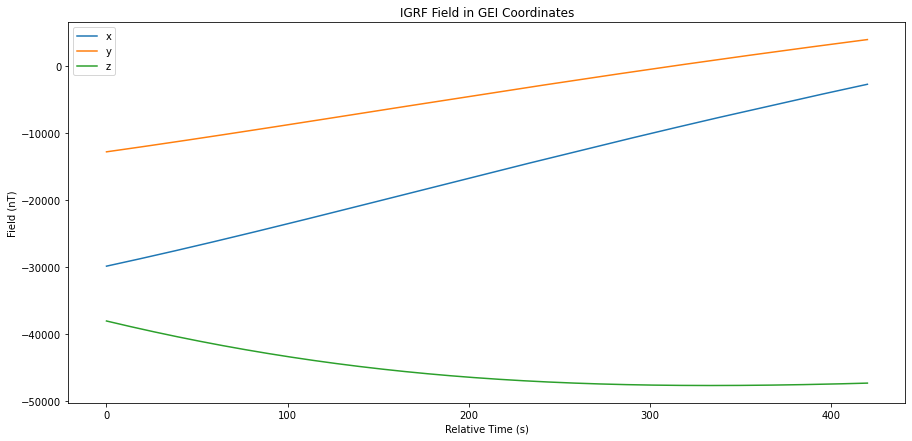

In [7]:
fig, ax = plt.subplots(1, figsize = (15, 7))

ax.plot(ctime, B_IGRF_GEI_x, label='x')
ax.plot(ctime, B_IGRF_GEI_y, label='y')
ax.plot(ctime, B_IGRF_GEI_z, label='z')

ax.set_title('IGRF Field in GEI Coordinates')
ax.set_xlabel('Relative Time (s)')
ax.set_ylabel('Field (nT)')
ax.legend()

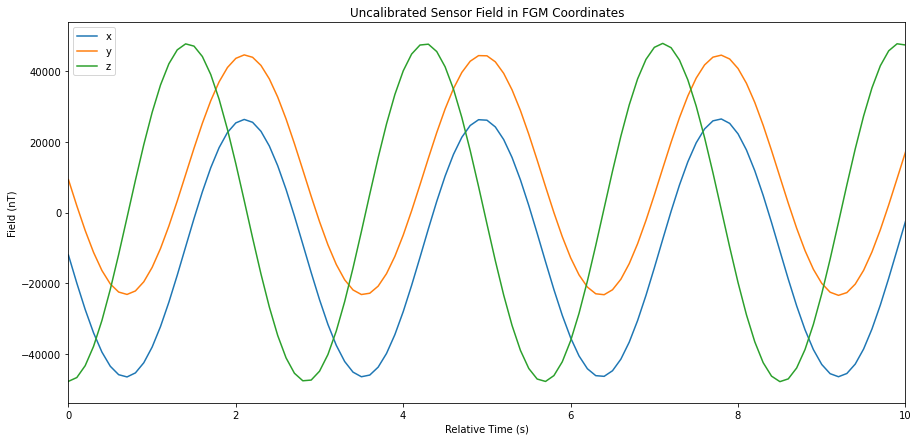

In [8]:
fig, ax = plt.subplots(1, figsize = (15, 7))

ax.plot(ctime, B_raw_FGM_x, label='x')
ax.plot(ctime, B_raw_FGM_y, label='y')
ax.plot(ctime, B_raw_FGM_z, label='z')

ax.set_title('Uncalibrated Sensor Field in FGM Coordinates')
ax.set_xlabel('Relative Time (s)')
ax.set_ylabel('Field (nT)')
ax.set_xlim(0, 10)
ax.legend()

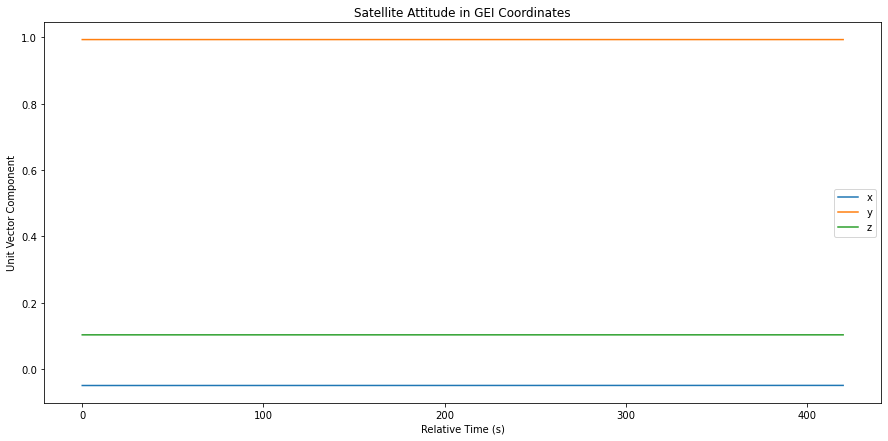

In [9]:
fig, ax = plt.subplots(1, figsize = (15, 7))

ax.plot(ctime, att_GEI_x, label='x')
ax.plot(ctime, att_GEI_y, label='y')
ax.plot(ctime, att_GEI_z, label='z')

ax.set_title('Satellite Attitude in GEI Coordinates')
ax.set_xlabel('Relative Time (s)')
ax.set_ylabel('Unit Vector Component')
ax.legend()

We can see how the IGRF field directions change in GEI coordinates.

In [10]:
# Unit vectors along the model IGRF field as a function of time
B_hat_IGRF_GEI_x = B_IGRF_GEI_x/np.sqrt(B_IGRF_GEI_x**2 + B_IGRF_GEI_y**2 + B_IGRF_GEI_z**2)
B_hat_IGRF_GEI_y = B_IGRF_GEI_y/np.sqrt(B_IGRF_GEI_x**2 + B_IGRF_GEI_y**2 + B_IGRF_GEI_z**2)
B_hat_IGRF_GEI_z = B_IGRF_GEI_z/np.sqrt(B_IGRF_GEI_x**2 + B_IGRF_GEI_y**2 + B_IGRF_GEI_z**2)

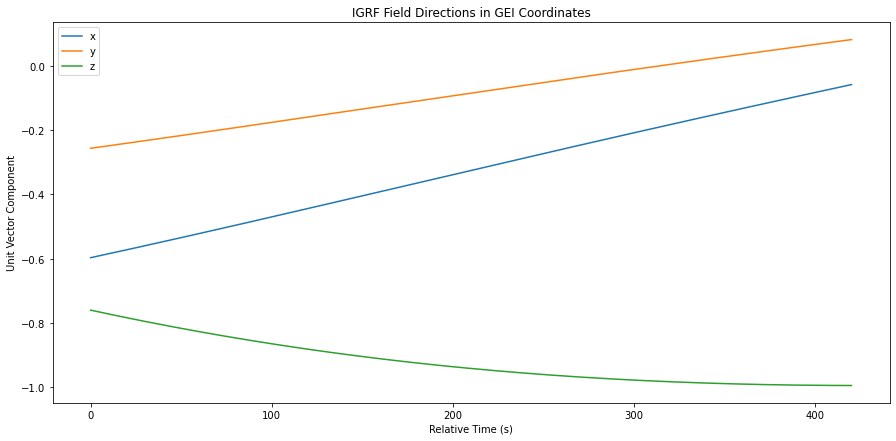

In [11]:
fig, ax = plt.subplots(1, figsize = (15, 7))

ax.plot(ctime, B_hat_IGRF_GEI_x, label='x')
ax.plot(ctime, B_hat_IGRF_GEI_y, label='y')
ax.plot(ctime, B_hat_IGRF_GEI_z, label='z')

ax.set_title('IGRF Field Directions in GEI Coordinates')
ax.set_xlabel('Relative Time (s)')
ax.set_ylabel('Unit Vector Component')

ax.legend()

We start from a imperfect guess of the spacecraft attitude.

In [12]:
u_hat_init = np.array([att_GEI_x[0], att_GEI_y[0], att_GEI_z[0]])
b_hat = np.array([B_hat_IGRF_GEI_x[0], B_hat_IGRF_GEI_y[0], B_hat_IGRF_GEI_z[0]])

In [13]:
u_hat_init

array([-0.04945728,  0.99342475,  0.10325335])

Next, we consider the following matrix that transforms DSC to GEI coordinates -

$$GR = \begin{pmatrix}
\frac{\hat{b} \times \hat{u}}{||\hat{b} \times \hat{u}||} & 
\frac{\hat{u} \times (\hat{b} \times \hat{u})}{||\hat{u} \times (\hat{b} \times \hat{u})||}& \hat{u}\\
\end{pmatrix}$$


An alternate representation of this matrix would be using the concept of a general rotation matrix -

$$GR = \begin{pmatrix}
\cos{\theta} + r_x^2(1-\cos(\theta)) & 
r_x r_y (1-\cos(\theta)) - r_z \sin(\theta) & 
r_x r_z (1-\cos(\theta)) + r_y \sin(\theta)\\
r_y r_x (1-\cos(\theta)) + r_z \sin(\theta) & 
\cos{\theta} + r_y^2(1-\cos(\theta)) & 
r_y r_z (1-\cos(\theta)) - r_x \sin(\theta)\\
r_z r_x (1-\cos(\theta)) - r_y \sin(\theta) & 
r_z r_y (1-\cos(\theta)) + r_x \sin(\theta) & 
\cos{\theta} + r_z^2(1-\cos(\theta))\\
\end{pmatrix}$$

This alternate representation is more amenable for correcting the attitude of the spacecraft. Therefore, let us obtain an equivalence between $(\hat{u}, \hat{b})$ and $(\hat{r}, \theta)$ (note that $\hat{r}$ is also a unit vector)

In [14]:
# Function for constructing the GR matrix using u_hat and b_hat

def orth_norm_mat_create(u_hat, b_hat):
    
    GR = np.zeros((3, 3))
            
    GR[:,0] = np.cross(b_hat, u_hat)
    GR[:,1] = np.cross(u_hat, np.cross(b_hat, u_hat))
    GR[:,2] = u_hat
    
    GR[:,0] /= np.linalg.norm(GR[:,0])
    GR[:,1] /= np.linalg.norm(GR[:,1])
    GR[:,2] /= np.linalg.norm(GR[:,2])    
    
    return GR

In [15]:
# Function for generating the GR matrix using r_x, r_y, r_z, and theta

def gen_rot_mat_create(r_x, r_y, r_z, theta):
    
    R = np.array([[np.cos(theta)+r_x**2*(1-np.cos(theta)), r_x*r_y*(1-np.cos(theta))-r_z*np.sin(theta), r_x*r_z*(1-np.cos(theta))+r_y*np.sin(theta)],
                  [r_y*r_x*(1-np.cos(theta))+r_z*np.sin(theta), np.cos(theta)+r_y**2*(1-np.cos(theta)), r_y*r_z*(1-np.cos(theta))-r_x*np.sin(theta)],
                  [r_z*r_x*(1-np.cos(theta))-r_y*np.sin(theta), r_z*r_y*(1-np.cos(theta))+r_x*np.sin(theta), np.cos(theta)+r_z**2*(1-np.cos(theta))]])
    
    return R

In [16]:
# Function to return the equivalent solution for r_hat and theta, given a particular u_hat and b_hat

def gen_rot_solve(u_hat, b_hat):
    
    # First create the GR matrix
    
    GR = orth_norm_mat_create(u_hat, b_hat)
    
    # Then solve for cos_theta using the trace of GR
    
    cos_theta = (np.trace(GR)-1)/2
    
    # You can uniquely get r_x^2 and r_y^2 from the first two diagonal entries of GR
    
    r_x_2 = (GR[0,0]-cos_theta)/(1-cos_theta)
    r_y_2 = (GR[1,1]-cos_theta)/(1-cos_theta)
    
    # Create a list of possible values for r_x, r_y, and r_z, given r_x^2 and r_y^2
    
    r_x_arr = np.array([-np.sqrt(r_x_2), np.sqrt(r_x_2)])
    r_y_arr = np.array([-np.sqrt(r_y_2), np.sqrt(r_y_2)])
    r_z_arr = np.array([-np.sqrt(1-r_x_2-r_y_2), np.sqrt(1-r_x_2-r_y_2)])
    
    # Using GR[0,1], get all possible values for sin_theta, given possible values for r_x, r_y, r_z
    
    sin_theta_arr_1 = []

    for r_x in r_x_arr:
        for r_y in r_y_arr:
            for r_z in r_z_arr:
                sin_theta = (r_x*r_y*(1-cos_theta)-GR[0,1])/r_z
                sin_theta_arr_1.append(sin_theta)

    sin_theta_arr_1 = np.array(sin_theta_arr_1)
    
    # Using GR[1,0], again get all possible values for sin_theta
    
    sin_theta_arr_2 = []

    for r_x in r_x_arr:
        for r_y in r_y_arr:
            for r_z in r_z_arr:
                sin_theta = (GR[1,0]-r_x*r_y*(1-cos_theta))/r_z
                sin_theta_arr_2.append(sin_theta)

    sin_theta_arr_2 = np.array(sin_theta_arr_2)
    
    # Concatenate all solutions for sin_theta, pick out the unique ones
    
    sin_theta_arr = np.unique(np.concatenate((sin_theta_arr_1, sin_theta_arr_2)))
    
    # Pick out the sin_theta such that sin^2(theta) + cos^2(theta) is as close 1 as possible
    
    sin_theta = sin_theta_arr[np.argmin(np.abs(sin_theta_arr**2+cos_theta**2-1))]
    
    # We now know the best value for sin^2(theta) (since that was the minimization condition)
    # We'll now proceed with possibilities of both plus and minus sin_theta
    
    sin_theta_arr_new = np.array([-np.abs(sin_theta), np.abs(sin_theta)])
    
    # Construct all possible GR matrices, given possibilities for r_x, r_y, r_z, and sin_theta
    # Also store in the corresponding r_x, r_y, r_z, and sin_theta that lead to a given GR matrix
    
    GR_arr = []
    solutions_arr = []
    
    for r_x in r_x_arr:
        for r_y in r_y_arr:
            for r_z in r_z_arr:
                for sin_theta in sin_theta_arr_new:
                    solutions_arr.append([r_x, r_y, r_z, sin_theta])
                    GR_arr.append([[cos_theta+r_x**2*(1-cos_theta), r_x*r_y*(1-cos_theta)-r_z*sin_theta, r_x*r_z*(1-cos_theta)+r_y*sin_theta],
                                 [r_y*r_x*(1-cos_theta)+r_z*sin_theta, cos_theta+r_y**2*(1-cos_theta), r_y*r_z*(1-cos_theta)-r_x*sin_theta],
                                 [r_z*r_x*(1-cos_theta)-r_y*sin_theta, r_z*r_y*(1-cos_theta)+r_x*sin_theta, cos_theta+r_z**2*(1-cos_theta)]])

    GR_arr = np.array(GR_arr)
    solutions_arr = np.array(solutions_arr)
    
    # Choose the solution where the corresponding GR matrix as "closest" to the actual one constructed from u_hat and b_hat
    
    solution = solutions_arr[np.argmin(np.abs(np.linalg.det(GR_arr-GR)))]
    
    # Reconstruct r_x, r_y, r_z, and sin_theta
    
    r_x_sol = solution[0]
    r_y_sol = solution[1]
    r_z_sol = solution[2]
    sin_theta_sol = solution[3]
    cos_theta_sol = cos_theta
    
    # Obtain theta given cos_theta and sin_theta
    
    if(cos_theta_sol>0 and sin_theta_sol>0):
        theta_sol = np.arcsin(sin_theta_sol)

    elif(cos_theta_sol<0 and sin_theta_sol>0):
        theta_sol = np.arccos(cos_theta_sol)

    elif(cos_theta_sol<0 and sin_theta_sol<0):
        theta_sol = 2*np.pi-np.arccos(cos_theta_sol)

    else:
        theta_sol = 2*np.pi+np.arcsin(sin_theta_sol)

    return r_x_sol, r_y_sol, r_z_sol, theta_sol

In [17]:
# Apply to above function to our situation

r_x_init, r_y_init, r_z_init, theta_r_init = gen_rot_solve(u_hat_init, b_hat)

We'll guess the spin-period of the spacecraft to be slightly off from the true value of 2.84s.

In [18]:
T_init = 2.84 + 1e-5
w_init = 2*np.pi/T_init

Let us compute the first zero-crossing time to get the zero-phase for rotation angles. This will help us go from RSC to DSC coordinates by using the matrix -


$$D = \begin{pmatrix}
\cos(\phi) & -\sin(\phi) & 0\\
\sin(\phi) & \cos(\phi) & 0\\
0 & 0 & 1
\end{pmatrix}$$

Where $\phi(t) = \omega t + \phi_0$.

In [19]:
# The following piece of code computes the first zero crossing in two stages, which helps us get the initial rotation phase

d_B_raw_FGM_z = np.gradient(B_raw_FGM_z)/np.gradient(ctime)

for j in range(len(ctime)-1):
    if(d_B_raw_FGM_z[j]*d_B_raw_FGM_z[j+1]<0 and d_B_raw_FGM_z[j]>0):
        y1 = d_B_raw_FGM_z[j]
        y2 = d_B_raw_FGM_z[j+1]
        x1 = ctime[j]
        x2 = ctime[j+1]
        t0_init = (y2*x1 - y1*x2)/(y2 - y1)
        break

phase_init = np.zeros(len(ctime))

idx = ((ctime-t0_init)>=-T_init/2) & ((ctime-t0_init)<=T_init/2)
phase_init[idx] = np.arcsin(d_B_raw_FGM_z[idx]/np.max(np.abs(d_B_raw_FGM_z[idx])))

for k in range(len(ctime)-1):
    if(phase_init[k]*phase_init[k+1]<0 and phase_init[k]>0):
        y1 = phase_init[k]
        y2 = phase_init[k+1]
        x1 = ctime[k]
        x2 = ctime[k+1]
        t0_init = (y2*x1 - y1*x2)/(y2 - y1)
        break
        
phi0_init = (-w_init*t0_init)%(2*np.pi)

Next, we write out the transformation that takes us from FGM to RSC coordinates -


$$\Gamma = \begin{pmatrix}
\cos(f) & \sin(f) & 0\\
0 & 0 & 1\\
\sin(f) & -\cos(f) & 0
\end{pmatrix}$$

In [20]:
f = 44*np.pi/180

# Gamma matrix
FGM_2_RSC = np.array([[np.cos(f),np.sin(f),0],[0,0,1],[np.sin(f),-np.cos(f),0]])

# Also storing its inverse for later use
RSC_2_FGM = np.linalg.inv(FGM_2_RSC)

First, let us take IGRF field from GEI coordinates to DSC

In [21]:
DSC_2_GEI_init = gen_rot_mat_create(r_x_init, r_y_init, r_z_init, theta_r_init)

GEI_2_DSC_init = np.linalg.inv(DSC_2_GEI_init)

In [22]:
# Function to apply a constant matrix to a time dependent field

def const_mat_apply(L, B_x, B_y, B_z):
    
    B_x_prime = L[0,0]*B_x + L[0,1]*B_y + L[0,2]*B_z
    B_y_prime = L[1,0]*B_x + L[1,1]*B_y + L[1,2]*B_z
    B_z_prime = L[2,0]*B_x + L[2,1]*B_y + L[2,2]*B_z
    
    return B_x_prime, B_y_prime, B_z_prime

In [23]:
B_IGRF_DSC_x, B_IGRF_DSC_y, B_IGRF_DSC_z = const_mat_apply(GEI_2_DSC_init, B_IGRF_GEI_x, B_IGRF_GEI_y, B_IGRF_GEI_z)

Next, respin IGRF fields from DSC to RSC coordinates

In [24]:
# Generate rotation phase angles, based on initial guesses of the zero-phase and omega
phi_init = w_init*ctime + phi0_init

In [25]:
# Function to apply a rotation matrix (time dependent) to a time dependent field

def rot_mat_apply(phi, B_x, B_y, B_z):
    
    B_x_rot = np.cos(phi)*B_x - np.sin(phi)*B_y
    B_y_rot = np.sin(phi)*B_x + np.cos(phi)*B_y
    B_z_rot = B_z
    
    return B_x_rot, B_y_rot, B_z_rot

In [26]:
B_IGRF_RSC_x, B_IGRF_RSC_y, B_IGRF_RSC_z = rot_mat_apply(-phi_init, B_IGRF_DSC_x, B_IGRF_DSC_y, B_IGRF_DSC_z)

Finally, take the IGRF fields from RSC coordinates to FGM coordinates

In [27]:
B_IGRF_FGM_x, B_IGRF_FGM_y, B_IGRF_FGM_z = const_mat_apply(RSC_2_FGM, B_IGRF_RSC_x, B_IGRF_RSC_y, B_IGRF_RSC_z)

Observe the residuals of the (transformed) IGRF model field from the raw FGM data

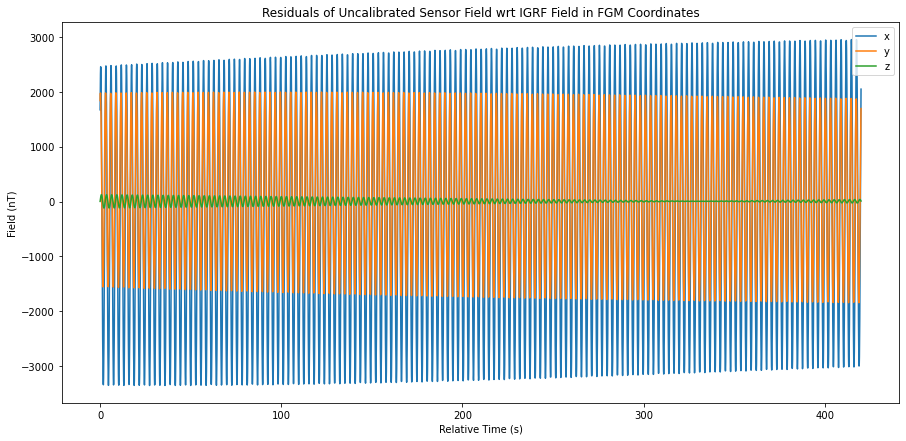

In [28]:
fig, ax = plt.subplots(1, figsize = (15, 7))

ax.plot(ctime, B_IGRF_FGM_x-B_raw_FGM_x, label='x')
ax.plot(ctime, B_IGRF_FGM_y-B_raw_FGM_y, label='y')
ax.plot(ctime, B_IGRF_FGM_z-B_raw_FGM_z, label='z')

ax.set_title('Residuals of Uncalibrated Sensor Field wrt IGRF Field in FGM Coordinates')
ax.set_xlabel('Relative Time (s)')
ax.set_ylabel('Field (nT)')
#ax.set_xlim(0, 10)
ax.legend()

Next, get the cal-params by comparing the IGRF fields in FGM coordinates to the raw sensor field

In [29]:
# Function to compute orthogonality matrix and offsets corresponding to a given raw sensor field and model field

def calc_cal_params(B_raw_FGM_x, B_raw_FGM_y, B_raw_FGM_z, B_IGRF_FGM_x, B_IGRF_FGM_y, B_IGRF_FGM_z):
    
    n = len(B_raw_FGM_x)
    
    b_FGM_cal = np.concatenate((B_raw_FGM_x, B_raw_FGM_y, B_raw_FGM_z))

    A_FGM_cal = np.zeros((3*n, 12))

    A_FGM_cal[0:n,0] = B_IGRF_FGM_x
    A_FGM_cal[0:n,1] = B_IGRF_FGM_y
    A_FGM_cal[0:n,2] = B_IGRF_FGM_z
    A_FGM_cal[0:n,3] = np.ones(n)
    A_FGM_cal[n:2*n,4] = B_IGRF_FGM_x
    A_FGM_cal[n:2*n,5] = B_IGRF_FGM_y
    A_FGM_cal[n:2*n,6] = B_IGRF_FGM_z
    A_FGM_cal[n:2*n,7] = np.ones(n)
    A_FGM_cal[2*n:3*n,8] = B_IGRF_FGM_x
    A_FGM_cal[2*n:3*n,9] = B_IGRF_FGM_y
    A_FGM_cal[2*n:3*n,10] = B_IGRF_FGM_z
    A_FGM_cal[2*n:3*n,11] = np.ones(n)

    A_FGM_cal = csc_matrix(A_FGM_cal)
    
    x_FGM_cal = lsqr(A_FGM_cal, b_FGM_cal, atol=1e-10, btol=1e-10)[0]    
    
    orth = np.array([[x_FGM_cal[0],x_FGM_cal[1],x_FGM_cal[2]], 
                     [x_FGM_cal[4], x_FGM_cal[5], x_FGM_cal[6]], 
                     [x_FGM_cal[8], x_FGM_cal[9], x_FGM_cal[10]]])

    offsets = np.array([x_FGM_cal[3], x_FGM_cal[7], x_FGM_cal[11]])
    
    calib = np.linalg.inv(orth)
    
    B_cal_FGM_x = calib[0, 0]*(B_raw_FGM_x-offsets[0]) + calib[0, 1]*(B_raw_FGM_y-offsets[1]) + calib[0, 2]*(B_raw_FGM_z-offsets[2])
    B_cal_FGM_y = calib[1, 0]*(B_raw_FGM_x-offsets[0]) + calib[1, 1]*(B_raw_FGM_y-offsets[1]) + calib[1, 2]*(B_raw_FGM_z-offsets[2])
    B_cal_FGM_z = calib[2, 0]*(B_raw_FGM_x-offsets[0]) + calib[2, 1]*(B_raw_FGM_y-offsets[1]) + calib[2, 2]*(B_raw_FGM_z-offsets[2]) 
    
    return orth, offsets, B_cal_FGM_x, B_cal_FGM_y, B_cal_FGM_z

In [30]:
orth, offsets, B_cal_FGM_x, B_cal_FGM_y, B_cal_FGM_z = calc_cal_params(B_raw_FGM_x, B_raw_FGM_y, B_raw_FGM_z, B_IGRF_FGM_x, B_IGRF_FGM_y, B_IGRF_FGM_z)

In [31]:
np.round(orth, 2), np.round(offsets, 2)

(array([[1.01, 0.05, 0.05],
        [0.02, 1.  , 0.04],
        [0.  , 0.  , 1.  ]]),
 array([ 2.07, -3.08, -5.17]))

Observe the residuals between the transformed model field and calibrated FGM data, so many orders of magnitude down!

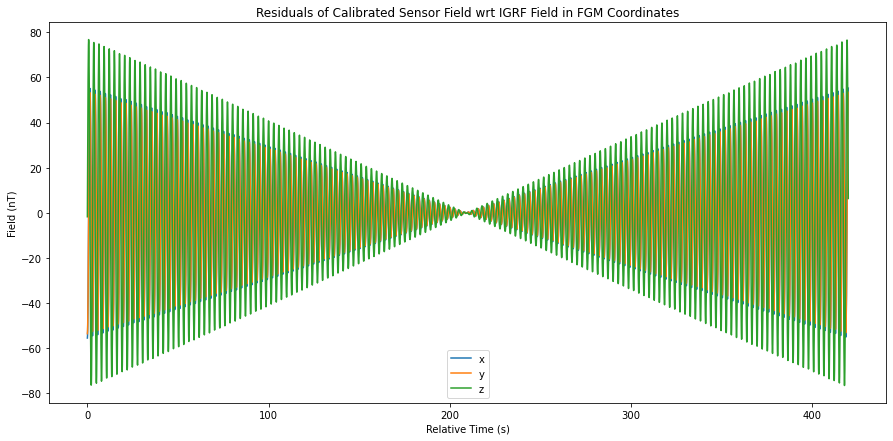

In [32]:
fig, ax = plt.subplots(1, figsize = (15, 7))

ax.plot(ctime, B_IGRF_FGM_x-B_cal_FGM_x, label='x')
ax.plot(ctime, B_IGRF_FGM_y-B_cal_FGM_y, label='y')
ax.plot(ctime, B_IGRF_FGM_z-B_cal_FGM_z, label='z')

ax.set_title('Residuals of Calibrated Sensor Field wrt IGRF Field in FGM Coordinates')
ax.set_xlabel('Relative Time (s)')
ax.set_ylabel('Field (nT)')
#ax.set_xlim(0, 10)
ax.legend()

Next, transform the calibrated FGM readings to RSC coordinates

In [33]:
B_cal_RSC_x, B_cal_RSC_y, B_cal_RSC_z = const_mat_apply(FGM_2_RSC, B_cal_FGM_x, B_cal_FGM_y, B_cal_FGM_z)

Next, we correct the zero-phase and angular velocity by comparing the calibrated FGM field in RSC coordinates with the model IGRF field in DSC coordinates. 

In [34]:
# Function that will help fit an angular velocity and zero-phase later
# The input, B, is the "unrolled" version of the time varying magnetic field
# w and phi0 are fitting parameters

def rot_mat_fit(time_concat, B, phi0, w):
    
    time = time_concat[:len(time_concat)//3]
    
    B_x = B[:len(time_concat)//3]
    B_y = B[len(time_concat)//3:2*len(time_concat)//3]
    B_z = B[2*len(time_concat)//3:]
    
    phi = w*time+phi0
    
    B_x_rot, B_y_rot, B_z_rot = rot_mat_apply(-phi, B_x, B_y, B_z)
    
    B_rot = np.concatenate((B_x_rot, B_y_rot, B_z_rot))
    
    return B_rot

In [35]:
# Prepare unrolled, concatenated versions of the timestamps, calibrated FGM field in RSC coordinates, 
# and model field in DSC coordinates

ctime_concat = np.concatenate((ctime, ctime, ctime))
B_cal_RSC = np.concatenate((B_cal_RSC_x, B_cal_RSC_y, B_cal_RSC_z))
B_IGRF_DSC = np.concatenate((B_IGRF_DSC_x, B_IGRF_DSC_y, B_IGRF_DSC_z))

In [36]:
# This helps fit the angular velocity and zero-phase, using initial guesses we had before

spin_opt, spin_covar = curve_fit(lambda time_concat, phi0, w: rot_mat_fit(time_concat, B_IGRF_DSC, phi0, w),
                                 ctime_concat, B_cal_RSC, p0 = [phi0_init, w_init])

In [37]:
# Finally, isolate the fitted parameters and regenerate rotation angles

phi0_final = spin_opt[0]
w_final = spin_opt[1]
phi_final = w_final*ctime + phi0_final

Let us regenerate the model IGRF field up to the FGM coordinates and recalibrate

In [38]:
# DSC to RSC

B_IGRF_RSC_x, B_IGRF_RSC_y, B_IGRF_RSC_z = rot_mat_apply(-phi_final, B_IGRF_DSC_x, B_IGRF_DSC_y, B_IGRF_DSC_z)

In [39]:
# RSC to FGM

B_IGRF_FGM_x, B_IGRF_FGM_y, B_IGRF_FGM_z = const_mat_apply(RSC_2_FGM, B_IGRF_RSC_x, B_IGRF_RSC_y, B_IGRF_RSC_z)

In [40]:
# Recalibrate for orthogonality matrix and offsets

orth, offsets, B_cal_FGM_x, B_cal_FGM_y, B_cal_FGM_z = calc_cal_params(B_raw_FGM_x, B_raw_FGM_y, B_raw_FGM_z, B_IGRF_FGM_x, B_IGRF_FGM_y, B_IGRF_FGM_z)

In [41]:
# Closer to the true values!

np.round(orth, 2), np.round(offsets, 2)

(array([[1.01, 0.05, 0.05],
        [0.02, 1.  , 0.04],
        [0.  , 0.  , 1.  ]]),
 array([ 2.11, -3.05, -5.  ]))

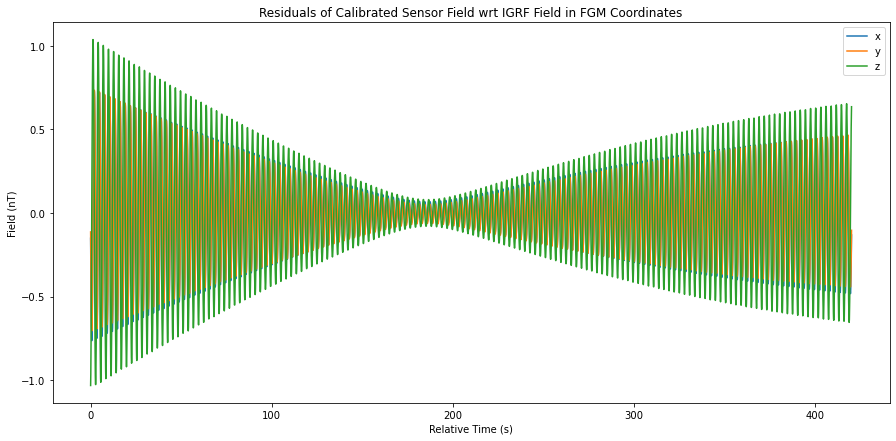

In [42]:
# Look at how the residuals went down in FGM coordinates again!

fig, ax = plt.subplots(1, figsize = (15, 7))

ax.plot(ctime, B_IGRF_FGM_x-B_cal_FGM_x, label='x')
ax.plot(ctime, B_IGRF_FGM_y-B_cal_FGM_y, label='y')
ax.plot(ctime, B_IGRF_FGM_z-B_cal_FGM_z, label='z')

ax.set_title('Residuals of Calibrated Sensor Field wrt IGRF Field in FGM Coordinates')
ax.set_xlabel('Relative Time (s)')
ax.set_ylabel('Field (nT)')
#ax.set_xlim(0, 10)
ax.legend()

As stated, the residuals went down plenty! Let us now take the calibrated sensor field down to the despun coordinates and correct for attitude.

In [43]:
# FGM to RSC

B_cal_RSC_x, B_cal_RSC_y, B_cal_RSC_z = const_mat_apply(FGM_2_RSC, B_cal_FGM_x, B_cal_FGM_y, B_cal_FGM_z)

In [44]:
# RSC to DSC

B_cal_DSC_x, B_cal_DSC_y, B_cal_DSC_z = rot_mat_apply(phi_final, B_cal_RSC_x, B_cal_RSC_y, B_cal_RSC_z)

In [45]:
# This function will help us fit the attitude of the spacecraft
# Similar to the function rot_mat_fit, this function accepts an "unrolled" version of the magnetic field
# r_x, r_y, r_z, and theta are the fitting parameters here

def gen_rot_mat_fit(time_concat, B, r_x, r_y, r_z, theta):
    
    time = time_concat[:len(time_concat)//3]
    
    B_x = B[:len(time_concat)//3]
    B_y = B[len(time_concat)//3:2*len(time_concat)//3]
    B_z = B[2*len(time_concat)//3:]
        
    B_x_gen_rot, B_y_gen_rot, B_z_gen_rot = const_mat_apply(gen_rot_mat_create(r_x, r_y, r_z, -theta),
                                                            B_x, B_y, B_z)
    
    B_gen_rot = np.concatenate((B_x_gen_rot, B_y_gen_rot, B_z_gen_rot))
    
    return B_gen_rot

In [46]:
# Produce unrolled versions of the calibrated FGM field in DSC coordinates and model IGRF field in GEI coordinates

B_cal_DSC = np.concatenate((B_cal_DSC_x, B_cal_DSC_y, B_cal_DSC_z))
B_IGRF_GEI = np.concatenate((B_IGRF_GEI_x, B_IGRF_GEI_y, B_IGRF_GEI_z))

In [47]:
# We obtain our fitting parameters using the initial guess for the general rotation matrix

att_opt, att_covar = curve_fit(lambda time_concat, r_x, r_y, r_z, theta: gen_rot_mat_fit(time_concat, B_IGRF_GEI, r_x, r_y, r_z, theta),
                                ctime_concat, B_cal_DSC, p0 = [r_x_init, r_y_init, r_z_init, theta_r_init])

In [48]:
# Isolate the fitted parameters and renormalize the unit vector r_hat

r_x_final = att_opt[0]/np.sqrt(att_opt[0]**2 + att_opt[1]**2 + att_opt[2]**2)
r_y_final = att_opt[1]/np.sqrt(att_opt[0]**2 + att_opt[1]**2 + att_opt[2]**2)
r_z_final = att_opt[2]/np.sqrt(att_opt[0]**2 + att_opt[1]**2 + att_opt[2]**2)

theta_r_final = att_opt[3]

Let us regenerate our IGRF model up to the FGM coordinates again and re-calibrate

In [49]:
# Reconstructing the general rotation matrix with corrected guesses of attitude

DSC_2_GEI_final = gen_rot_mat_create(r_x_final, r_y_final, r_z_final, theta_r_final)

GEI_2_DSC_final = np.linalg.inv(DSC_2_GEI_final)

In [50]:
# GEI to DSC

B_IGRF_DSC_x, B_IGRF_DSC_y, B_IGRF_DSC_z = const_mat_apply(GEI_2_DSC_final, B_IGRF_GEI_x, B_IGRF_GEI_y, B_IGRF_GEI_z)

In [51]:
# DSC to RSC

B_IGRF_RSC_x, B_IGRF_RSC_y, B_IGRF_RSC_z = rot_mat_apply(-phi_final, B_IGRF_DSC_x, B_IGRF_DSC_y, B_IGRF_DSC_z)

In [52]:
# RSC to FGM

B_IGRF_FGM_x, B_IGRF_FGM_y, B_IGRF_FGM_z = const_mat_apply(RSC_2_FGM, B_IGRF_RSC_x, B_IGRF_RSC_y, B_IGRF_RSC_z)

In [53]:
# One last time, recalibrate the FGM data for the orthogonality matrix and offsets

orth, offsets, B_cal_FGM_x, B_cal_FGM_y, B_cal_FGM_z = calc_cal_params(B_raw_FGM_x, B_raw_FGM_y, B_raw_FGM_z, B_IGRF_FGM_x, B_IGRF_FGM_y, B_IGRF_FGM_z)

In [54]:
# Even closer to the real values!

np.round(orth, 2), np.round(offsets, 2)

(array([[1.01, 0.05, 0.05],
        [0.02, 1.  , 0.04],
        [0.  , 0.  , 1.  ]]),
 array([ 2.04, -2.98, -5.  ]))

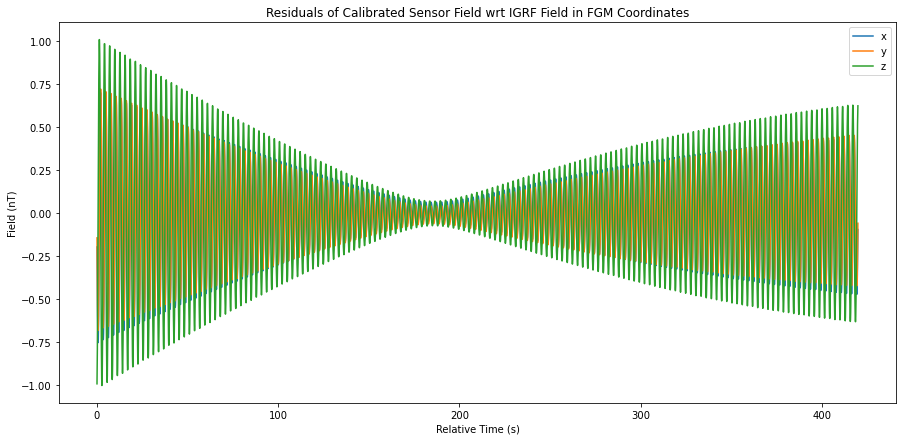

In [55]:
# Residuals don't really go down in these coordinates, but let us check other coordinate systems

fig, ax = plt.subplots(1, figsize = (15, 7))

ax.plot(ctime, B_IGRF_FGM_x-B_cal_FGM_x, label='x')
ax.plot(ctime, B_IGRF_FGM_y-B_cal_FGM_y, label='y')
ax.plot(ctime, B_IGRF_FGM_z-B_cal_FGM_z, label='z')

ax.set_title('Residuals of Calibrated Sensor Field wrt IGRF Field in FGM Coordinates')
ax.set_xlabel('Relative Time (s)')
ax.set_ylabel('Field (nT)')
#ax.set_xlim(0, 10)
ax.legend()

Despin the calibrated FGM field down to GEI

In [56]:
# FGM to RSC

B_cal_RSC_x, B_cal_RSC_y, B_cal_RSC_z = const_mat_apply(FGM_2_RSC, B_cal_FGM_x, B_cal_FGM_y, B_cal_FGM_z)

In [57]:
# RSC to DSC

B_cal_DSC_x, B_cal_DSC_y, B_cal_DSC_z = rot_mat_apply(phi_final, B_cal_RSC_x, B_cal_RSC_y, B_cal_RSC_z)

In [58]:
# DSC to GEI

B_cal_GEI_x, B_cal_GEI_y, B_cal_GEI_z = const_mat_apply(DSC_2_GEI_final, B_cal_DSC_x, B_cal_DSC_y, B_cal_DSC_z)

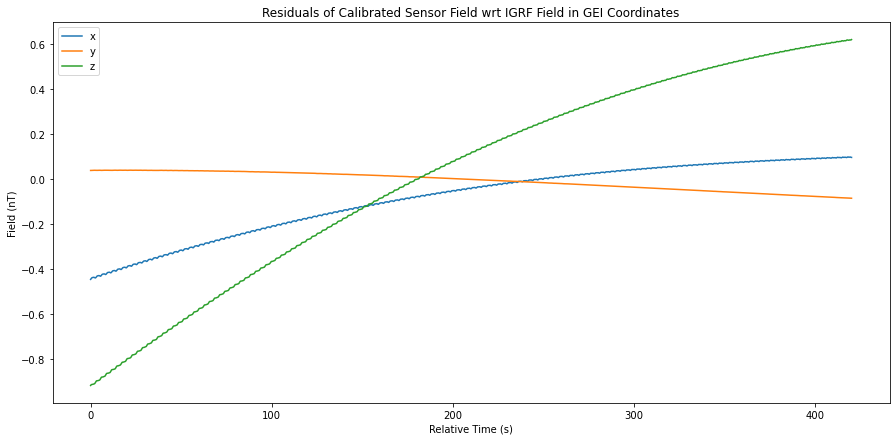

In [59]:
# The residuals are indeed very small, smaller than that in 4-const_w_calibrate_iter.ipynb!

fig, ax = plt.subplots(1, figsize = (15, 7))

ax.plot(ctime, B_IGRF_GEI_x-B_cal_GEI_x, label='x')
ax.plot(ctime, B_IGRF_GEI_y-B_cal_GEI_y, label='y')
ax.plot(ctime, B_IGRF_GEI_z-B_cal_GEI_z, label='z')

ax.set_title('Residuals of Calibrated Sensor Field wrt IGRF Field in GEI Coordinates')
ax.set_xlabel('Relative Time (s)')
ax.set_ylabel('Field (nT)')
#ax.set_xlim(0, 10)
ax.legend()